# ALAS1 Strain Clustering
# This notebook uses K-means clustering to group strains by ALAS1_Combined expression from a 1000-row Bgee RNA-Seq dataset.
# Responds to community feedback on outliers (e.g., ~150 minutes) by analyzing their cluster assignments.

In [66]:
# import libaries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score

# Load dataset

In [67]:
df = pd.read_csv('alas1_expression_data.csv')
df.head()

,Gene name,Expression level,Read count,Strain,Time_min,Expression_combined,Strain_Encoded,Cluster,ALAS1_combined
0,ALAS1,0.036724,0.186657,White,0,0.111691,1,1,0.111691
1,ALAS1,0.059476,0.308144,White,1,0.183810,1,1,0.183810
2,ALAS1,0.027832,0.138351,Black or African American,2,0.083092,0,2,0.083092
3,ALAS1,0.043375,0.100492,confidential_restricted_data,3,0.071933,2,0,0.071933
4,ALAS1,0.047138,0.142381,White,4,0.094760,1,1,0.094760


# Preprosessing: Ensure numeric colums

In [68]:
df[['Expression level', 'Read count']] = df[['Expression level', 'Read count']].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Normalise and compute ALAS1 Expression combined

In [69]:
scaler = MinMaxScaler()
df['Expression level'] = scaler.fit_transform(df[['Expression level']])
df['Read count'] = scaler.fit_transform(df[['Read count']])
df['ALAS1_combined'] = (df['Expression level'] + df['Read count']) / 2

# Encode strain 

In [70]:
le = LabelEncoder()
df['Strain_Encoded']=le.fit_transform(df['Strain'])

# features for clustering

In [71]:
X = df[['ALAS1_combined', 'Strain_Encoded']]

# K-means clustering (k=3, assuming 3 distinct expression groups)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)
df['Cluster']

# Evaluate clustering

In [73]:
sil_score = silhouette_score(X, df['Cluster'])
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.9479


# Identify outliers (from previous feedback, ~150 minutes in Read Count Visualizer)
# Since this dataset lacks Time_min, use IQR on Expression_Combined

In [74]:
Q1 = df['ALAS1_combined'].quantile(0.25)
Q3 = df['ALAS1_combined'].quantile(0.75)
IQR = Q1 - Q3
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
if IQR <= 0:
    print("Warning: IQR is zero or negative, checking data")
    sorted_data = df['ALAS1_combined'].sort_values()
    Q1 = sorted_data.quantile(0.25)
    Q3 = sorted_data.quantile(0.75)
    IQR = Q3-Q1

    print(f"Q1: {Q1}, Q3: {Q3}, IQR:{IQR}")
outliers = df[(df['ALAS1_combined'] < Q1 - 3 *IQR) | (df['ALAS1_combined']> Q3 + 3 * IQR)]
print("number of outliers:", len(outliers))
#print(outliers[['Strain', 'ALAS1_combined', 'Cluster']])

Q1: 0.0287526628050946, Q3: 0.0696964354518341, IQR:0.0409437726467395
number of outliers: 37


# Visualize clusters

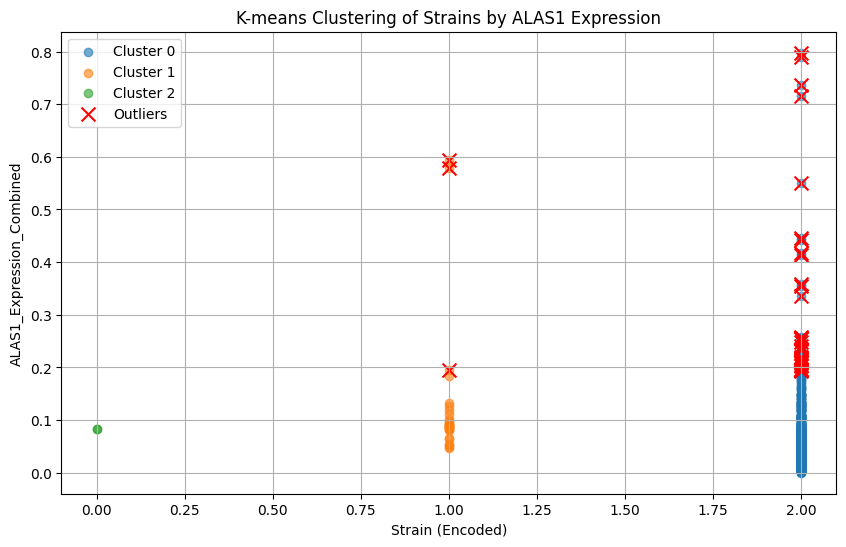

In [75]:
plt.figure(figsize=(10, 6))
for cluster in range(3):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Strain_Encoded'], cluster_data['ALAS1_combined'], 
                label=f"Cluster {cluster}", alpha=0.6)
plt.scatter(outliers['Strain_Encoded'], outliers['ALAS1_combined'], c='red', marker='x', s=100, label='Outliers')
plt.xlabel('Strain (Encoded)')
plt.ylabel('ALAS1_Expression_Combined')
plt.title('K-means Clustering of Strains by ALAS1 Expression')
plt.legend()
plt.grid(True)
plt.savefig('Alas1_cluster_scatter.png')
plt.show()   

# Analyse Outliers

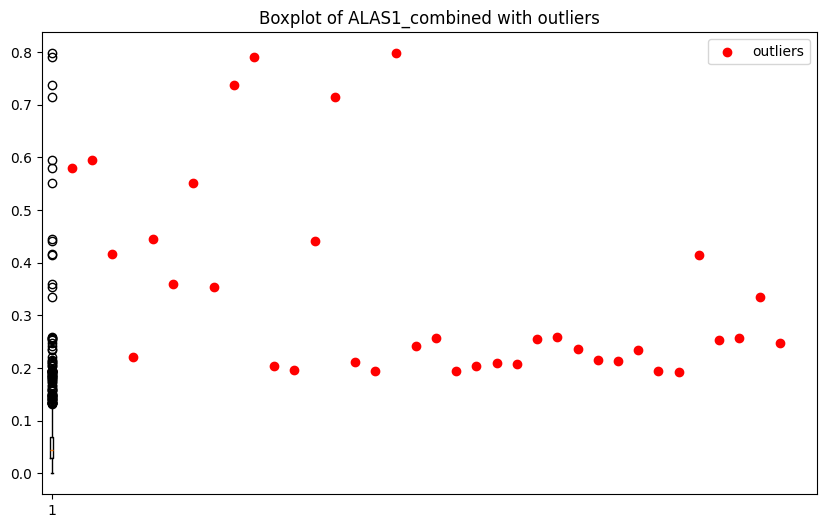

In [76]:

#Visualise thier distribution
plt.figure(figsize=(10, 6))
plt.boxplot(df['ALAS1_combined'])
plt.scatter(range(1, len(outliers) + 1), outliers['ALAS1_combined'], color='red', label='outliers')
plt.title('Boxplot of ALAS1_combined with outliers')
plt.legend()
plt.savefig('alas1_combined_boxplot_with_outliers.png')
plt.show()

# Test outlier impact

In [89]:

df_no_outliers = df[~((df['ALAS1_combined'] < Q1 - 3 * IQR)| (df['ALAS1_combined']>Q3 + 3 * IQR))]
df_no_outliers = df_no_outliers.reset_index(drop=True)
df_no_outliers.to_csv('df_clean.csv', index=False)
kmeans = KMeans(n_clusters=3, random_state=42)
df_no_outliers['Cluster'] = kmeans.fit_predict(df_no_outliers[['ALAS1_combined', 'Strain_Encoded']])
sil_score = silhouette_score(df_no_outliers[['ALAS1_combined', 'Strain_Encoded']], df_no_outliers['Cluster'])
print(f"Silhouette Score without outliers: {sil_score:.4f}")


Silhouette Score without outliers: 0.9649


# Verify the change

In [88]:
# Check the exact modification
print("Current n_clusters:", kmeans.n_clusters)
len(df_no_outliers) == len(df) - len(outliers)
print("Outliers removed?", len(df_no_outliers) < 1000)

Current n_clusters: 3
Outliers removed? True


# Re -run with validation

In [80]:
df_no_outliers.head
df_clean= pd.read_csv('df_clean.csv')
X = df_clean[['ALAS1_combined', 'Strain_Encoded']]
kmeans = KMeans(n_clusters=3, random_state=43)
df_clean['cluster'] = kmeans.fit_predict(X)
new_sil_score = silhouette_score(X, df_clean['cluster'])
print(f"Silhouette Score with new random_state: {new_sil_score:.4f}")



Silhouette Score with new random_state: 0.9649


# Visualize the result with cleaned data

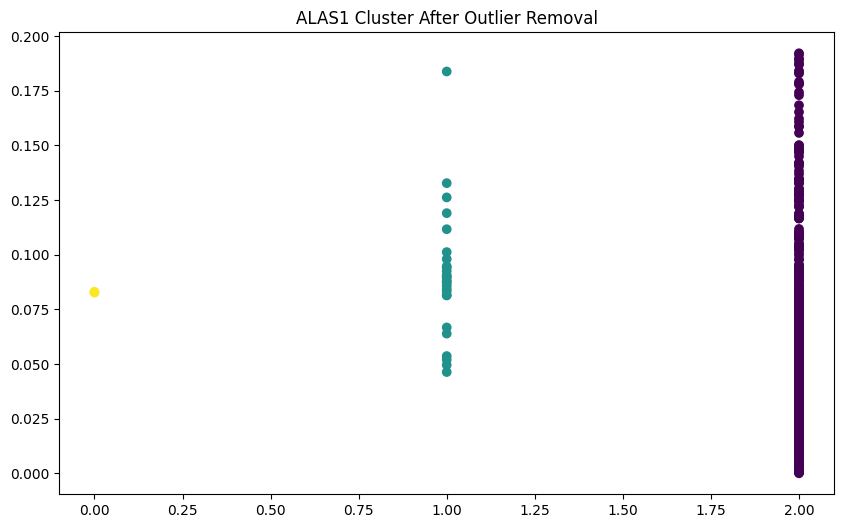

In [84]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Strain_Encoded'], df_clean['ALAS1_combined'], c=df_clean['cluster'], cmap='viridis')
plt.title('ALAS1 Cluster After Outlier Removal')
plt.savefig('alas1_clusters_cleaned.png')
plt.show()

# Save updated dataset with cluster assignments

In [85]:
df_clean.to_csv('Alas1_expression_clean_data.csv', index=False)
